In [ ]:
import os
import time
import traceback
import numpy as np
import pandas as pd
from dataloader import TrimodalLoader
from model import TrimodalModel
import torch


In [ ]:


def load_iris():
    """Loads iris features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../iris/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"iris_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels
        

In [3]:
def load_fingerprint():
    """Loads fingerprint features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../fingerprint/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"fp_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [4]:
def load_face():
    """Loads face features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../face/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"face_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [5]:
if len(os.listdir("feats")) == 0:
    emb_iris, lab_iris = load_iris()
    emb_fp, lab_fp = load_fingerprint()
    emb_face, lab_face = load_face()
else:
    emb_iris = pd.read_csv("feats/iris.csv")
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

In [6]:
if len(os.listdir("feats")) == 0:

    print(len(lab_iris), len(lab_fp), len(lab_face))
    emb_iris["label"] = lab_iris
    emb_fp["label"] = lab_fp
    emb_face["label"] = lab_face

    emb_iris.to_csv("feats/iris.csv", index=False)
    emb_fp.to_csv("feats/fingerprint.csv", index=False)
    emb_face.to_csv("feats/face.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris.csv")    
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

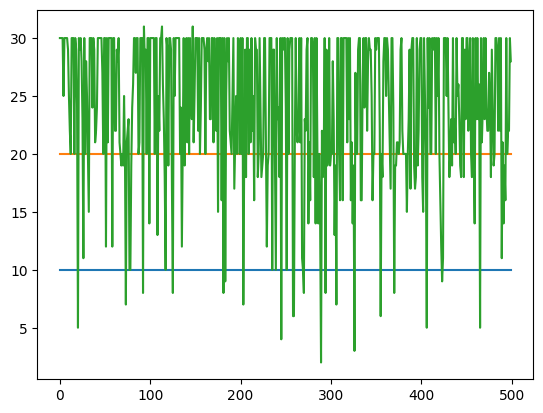

In [7]:
import matplotlib.pyplot as plt
plt.plot(emb_iris["label"].value_counts().sort_index())
plt.plot(emb_fp["label"].value_counts().sort_index())
plt.plot(emb_face["label"].value_counts().sort_index()) 

In [8]:
# Prepare dataloader

train_subjects_uniq = len(emb_iris["label"].unique()) // 5
train_subjects = emb_iris["label"].unique()[:train_subjects_uniq]
test_subjects = emb_iris["label"].unique()[train_subjects_uniq:]

iris_train = emb_iris[emb_iris["label"].isin(train_subjects)]
fp_train = emb_fp[emb_fp["label"].isin(train_subjects)]
face_train = emb_face[emb_face["label"].isin(train_subjects)]


iris_test = emb_iris[emb_iris["label"].isin(test_subjects)]
fp_test = emb_fp[emb_fp["label"].isin(test_subjects)]
face_test = emb_face[emb_face["label"].isin(test_subjects)]


iris_train_x, iris_train_y = iris_train.drop("label", axis=1), iris_train["label"]
fp_train_x, fp_train_y = fp_train.drop("label", axis=1), fp_train["label"]
face_train_x, face_train_y = face_train.drop("label", axis=1), face_train["label"]


iris_test_x, iris_test_y = iris_test.drop("label", axis=1), iris_test["label"]
fp_test_x, fp_test_y = fp_test.drop("label", axis=1), fp_test["label"]
face_test_x, face_test_y = face_test.drop("label", axis=1), face_test["label"]

In [9]:
list(iris_train_y)[:10], list(fp_train_y)[:10], list(face_train_y)[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
len(iris_train_y), len(fp_train_y), len(face_train_y)

(1000, 2000, 2562)

In [11]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

False

In [12]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

False

In [ ]:

dataloader = TrimodalLoader(
    torch.tensor(iris_train_x.values, dtype=torch.float32), 
    torch.tensor(fp_train_x.values, dtype=torch.float32), 
    torch.tensor(face_train_x.values, dtype=torch.float32), 
    torch.tensor(iris_train_y.values, dtype=torch.long),
    torch.tensor(fp_train_y.values, dtype=torch.long),
    torch.tensor(face_train_y.values, dtype=torch.long))

In [ ]:
iris_train_y

0         0
1         0
2         0
3         0
4         0
       ... 
9995    189
9996    189
9997    189
9998    189
9999    189
Name: label, Length: 10000, dtype: int64

In [ ]:
iris_train.iloc[0].shape

(1409,)

In [ ]:
# initialize
batch_size = 32
device = "cpu"
train_path = "tmp/train/"
max_steps = 100
log_freq = 2
summary_freq = 5
save_freq = 5
sleep_ratio = 0
restore_path = None
global_step = 0
os.environ["CUDA_VISIBLE_DEVICES"] = device
os.makedirs(train_path, exist_ok=True)

In [ ]:
# Prepare model
model = TrimodalModel()
input_size_list = [iris_train.iloc[0].shape[0], fp_train_x.iloc[0].shape[0], face_train_x.iloc[0].shape[0]]
print(input_size_list)

print(input_size_list)
model.prepare(is_training=True, input_size_list=input_size_list, global_step=global_step, n_classes=len(iris_train_y.unique()))

[1409, 1408, 512]
[1409, 1408, 512]
Created docking_0 with input size 1409 and output size 256
Parameter containing:
tensor([[-0.0254,  0.0060, -0.0019,  ...,  0.0079, -0.0171, -0.0014],
        [-0.0017,  0.0160,  0.0090,  ..., -0.0122, -0.0026, -0.0199],
        [ 0.0244, -0.0090,  0.0028,  ..., -0.0129, -0.0097,  0.0050],
        ...,
        [-0.0027,  0.0205, -0.0052,  ...,  0.0192, -0.0032, -0.0098],
        [ 0.0016, -0.0033,  0.0126,  ...,  0.0248, -0.0214, -0.0214],
        [-0.0134, -0.0224, -0.0169,  ...,  0.0053,  0.0180,  0.0197]],
       requires_grad=True)
Created docking_1 with input size 1408 and output size 256
Parameter containing:
tensor([[ 0.0008,  0.0122,  0.0131,  ...,  0.0195,  0.0130, -0.0197],
        [-0.0224, -0.0123, -0.0115,  ...,  0.0260, -0.0188,  0.0071],
        [ 0.0146, -0.0225, -0.0263,  ..., -0.0262,  0.0174,  0.0244],
        ...,
        [-0.0132,  0.0214, -0.0074,  ...,  0.0246, -0.0171, -0.0225],
        [ 0.0080,  0.0151, -0.0197,  ...,  0.017

In [ ]:
# model > restore
if restore_path is not None:
    model.restore(ckpt_path=restore_path)
    print("restored the model")

# model > summary
summary_path = os.path.join(train_path, "summary")

In [ ]:
print("begin training")
local_train_step = 0
losses = []
try:
    while model.global_step < max_steps:
        global_train_step = model.global_step + 1
        local_train_step += 1

        start_time = time.time()


        input_list, truth_list = dataloader.get_batch(
            batch_size=batch_size
        )  # [mod1, mod2, ...], label
        truth_list = torch.as_tensor(
            [int(label) for label in truth_list],  # Convert NumPy scalar arrays to Python integers
            dtype=torch.long,
            device=device)
        
        print(truth_list)
        loss = model.train_step(
            input_list=input_list, truth_list=truth_list
        )
        losses.append(loss)
        print(loss)
        duration = time.time() - start_time

        if local_train_step % log_freq == 0:
            print(
                "step %d, loss %.6f (%.3f sec/batch)"
                % (global_train_step, loss, duration)
            )

        if local_train_step % save_freq == 0:
            model.save(base_path=train_path)
            print("saved a model checkpoint at step %d" % (global_train_step))

except KeyboardInterrupt:
    print("interrupted (KeyboardInterrupt)")
except Exception as e:
    print(traceback.format_exc())

# finalize
print("finished")


begin training
tensor([128,  14, 141, 171, 156, 149, 153, 143, 143, 144, 171, 117,  17, 181,
        169, 151, 186, 180, 139, 179,  10, 123, 135, 170, 173, 137, 110, 130,
        145, 163, 178, 163])
torch.Size([45056]) torch.Size([45056]) torch.Size([16384])
[1409, 1408, 512]
Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_23608\1749394961.py", line 21, in <module>
    loss = model.train_step(
  File "c:\Users\sebas\Desktop\repos\Image-Based-Biometry\research_project\src\embracenet\model.py", line 101, in train_step
    output_tensor = self.model(input_tensors)  # Pass modality list to model
  File "c:\Users\sebas\Desktop\repos\Image-Based-Biometry\research_project\research_venv\lib\site-packages\torch\nn\modules\module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\sebas\Desktop\repos\Image-Based-Biometry\research_project\research_venv\lib\site-packages\torch\nn\modules\module.py", line 1562, i

In [ ]:
45056 / 256

176.0

In [ ]:
torch.cuda.is_available()

False

In [ ]:
input_size_list

[1409, 1408, 512]

In [ ]:
512 * 32

16384

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

sigma = 5
kernel_size = 11  # Choose an odd number
kernel = gaussian_kernel(kernel_size, sigma)
smoothed_vector = np.convolve(losses, kernel, mode='same')

plt.plot(losses, label="Original loss")
plt.plot(smoothed_vector[5:-5], label="Smoothed loss")
plt.legend()
plt.title("EmbraceNet Loss")


ValueError: v cannot be empty